### EDA Profiling - Parte 2

In [8]:
## Usamos el mismo dataset de la parte 1 para hacer EDA profiling (no hay modificaciones en los datos)

import pandas as pd

train_df = pd.read_csv("Parte 2/entrenamiento.csv")

Genero un mapa para visualizar los datos

In [ ]:
import pandas as pd
import numpy as np
import folium

# ========= 0) Helpers
def to_float(s):
    # Convierte "−34,6037" -> -34.6037 y maneja strings
    if pd.isna(s):
        return np.nan
    if isinstance(s, (int, float, np.number)):
        return float(s)
    s = str(s).strip().replace(",", ".")
    try:
        return float(s)
    except:
        return np.nan

# Bounding box aproximado de Argentina
LAT_MIN, LAT_MAX = -56.0, -21.0
LON_MIN, LON_MAX = -75.0, -53.0

def in_argentina(lat, lon):
    return (LAT_MIN <= lat <= LAT_MAX) and (LON_MIN <= lon <= LON_MAX)

# ========= 1) Limpieza de lat/lon
train_df["lat"] = train_df["lat"].apply(to_float)
train_df["lon"] = train_df["lon"].apply(to_float)

# elimina NaN
geo = train_df.dropna(subset=["lat", "lon"]).copy()

# ========= 2) Corregir lat/lon invertidas fila a fila
# Si (lat, lon) NO cae en AR pero (lon, lat) SÍ cae, entonces invertir
mask_swap = (~geo.apply(lambda r: in_argentina(r["lat"], r["lon"]), axis=1)) & \
            ( geo.apply(lambda r: in_argentina(r["lon"], r["lat"]), axis=1))

geo.loc[mask_swap, ["lat", "lon"]] = geo.loc[mask_swap, ["lon", "lat"]].values

# ========= 3) Filtrar por bounding box de Argentina (quita outliers)
# geo = geo[geo.apply(lambda r: in_argentina(r["lat"], r["lon"]), axis=1)].copy()


# ========= 4) Muestreo de 10.000 puntos
if len(geo) > 10_000:
    geo = geo.sample(n=10_000, random_state=42)

# Nombre para tooltip si no existe
if "localidad" not in geo.columns:
    # Probamos usar l2/l3 como etiqueta si existen; si no, el índice
    if "l3" in geo.columns:
        geo["localidad"] = geo["l3"].fillna(geo.get("l2", "")).fillna("").replace("", np.nan)
    elif "l2" in geo.columns:
        geo["localidad"] = geo["l2"]
    else:
        geo["localidad"] = "prop_" + geo.index.astype(str)

    geo["localidad"] = geo["localidad"].fillna(
        pd.Series(geo.index.astype(str), index=geo.index).map(lambda i: f"prop_{i}")
    )

# ========= 5) Crear mapa y dibujar puntos
center = [geo["lat"].mean(), geo["lon"].mean()]
m = folium.Map(location=center, zoom_start=5, tiles="CartoDB positron")

for _, r in geo.iterrows():
    tooltip = str(r["localidad"])
    popup = folium.Popup(
        f"<b>{tooltip}</b><br>Lat: {r['lat']:.6f}<br>Lon: {r['lon']:.6f}",
        max_width=260
    )
    folium.CircleMarker(
        location=[r["lat"], r["lon"]],  # OJO: folium espera [lat, lon]
        radius=3,
        fill=True,
        fill_opacity=0.8,
        weight=0.5,
        popup=popup,
        tooltip=tooltip
    ).add_to(m)

m.save("mapa_propiedades.html")
print("OK → mapa_propiedades_sin_cluster.html")

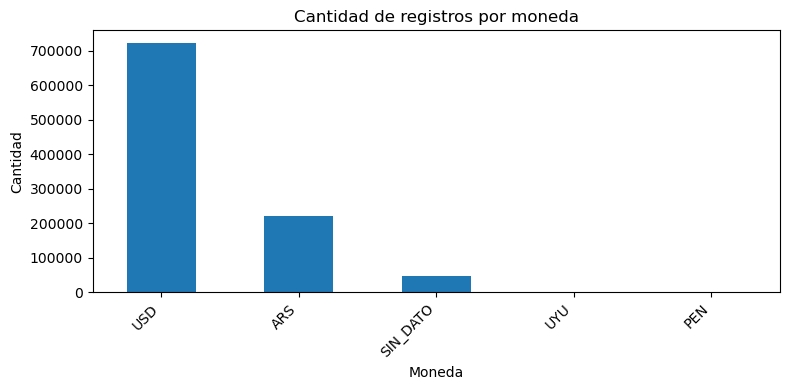

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Conteo de monedas (mostrando también los NaN)
counts = (
    train_df["currency"]
    .astype("string").str.strip().str.upper()
    .fillna("SIN_DATO")
    .value_counts()
)

plt.figure(figsize=(8,4))
counts.plot(kind="bar")
plt.xlabel("Moneda")
plt.ylabel("Cantidad")
plt.title("Cantidad de registros por moneda")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

se observa que hay registros en distintas monedas, se debe normalizar para que esté todo en USD. esta diferencia de escala en el dato a predecir generar errores de prediccion altísimos (RMSE> 5000)